# Machine Learning Project : Capital Fund Management
_Arnaud Lecoules & Alain Soltani_

The goal of this challenge is to predict for several American stocks how much volume will be traded during a certain period of time. Because American stock markets open at 9:30am and close at 4:00pm, we are provided with trading data between 9:30am and 2:00pm and asked to predict trading activity from 2:00pm to 4:00pm.

In [26]:
%matplotlib inline
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('ggplot')

The measure of the error choosen by the challenge is the Mean Absolute Percentage Error (MAPE).

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## I. Descriptive Statistics
The training data contains 613220 examples for 1882 different dates and 352 examples.    
The testing data contains 614098 examples, for which we aim at predicting the target values.

In [28]:
Training = pd.read_csv('training_input.csv', delimiter=',')
Output = pd.read_csv('training_output.csv', delimiter=';')
Testing = pd.read_csv('testing_input.csv', delimiter=',')

In [29]:
print Training.shape
Training.head()

(613220, 57)


,ID,date,product_id,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,13:10:00,13:15:00,13:20:00,13:25:00,13:30:00,13:35:00,13:40:00,13:45:00,13:50:00,13:55:00
0,1,1,236,24138818.08,2457975.00,741777.14,973487.28,764018.92,1074769.92,3056492.88,...,810609.36,818269.86,629216.64,1467907.56,984992.90,959853.30,892596.88,528573.62,973928.60,972596.43
1,2,1,238,8897508.62,104198.40,61840.92,78523.02,128729.16,60789.84,18072.62,...,19140.84,12707.50,25131.87,24124.80,46132.35,51850.26,46478.41,17199.00,34500.62,37690.24
2,3,1,242,6461968.95,109497.00,152577.00,164024.00,204372.00,321545.70,346236.00,...,96203.00,33978.00,239729.60,67860.00,68478.00,105222.24,101646.00,79128.00,101248.00,367120.00
3,4,1,243,6822223.20,220467.28,161594.35,264893.44,300326.20,707391.68,327428.00,...,437946.60,7096.00,514560.06,1395147.39,984468.82,565263.30,286416.00,71518.14,155752.10,123690.00
4,5,1,261,36632811.84,4470974.95,1448461.05,1500694.38,944346.50,958685.76,1685234.07,...,429049.72,289330.13,578565.65,358484.80,440292.16,795697.65,565374.30,832022.43,1425134.40,2310369.30


In [30]:
print Output.shape
Output.head()

(613220, 2)


,ID,TARGET
0,1,36523251.91
1,2,5645118.17
2,3,8103847.53
3,4,20047809.46
4,5,36833075.51


In [31]:
print Testing.shape
Testing.head()

(614098, 57)


,ID,date,product_id,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,13:10:00,13:15:00,13:20:00,13:25:00,13:30:00,13:35:00,13:40:00,13:45:00,13:50:00,13:55:00
0,618557,1885,236,2302200.0360,988064.0616,543489.991500,505995.0237,741703.9884,447160.007000,711509.977800,...,147245.9931,243313.99620,179172.0056,268716.0000,192089.997000,108850.9983,294813.9816,243238.007600,159849.997500,242934.0000
1,618558,1885,238,87239.9964,50791.9986,116016.003200,57944.0000,94418.9961,247689.993200,174960.004800,...,58184.0024,21809.99910,29104.0008,72699.9970,14552.000400,72809.9980,94809.0000,21887.999700,168061.000000,43848.0012
2,618559,1885,242,558983.7500,268320.7600,359088.736475,397291.8800,377122.4800,433278.553887,786367.949364,...,133100.0050,374543.41407,228502.0000,114207.9957,189646.642857,117518.8000,105959.9100,154334.714224,38355.558564,56175.0000
3,618560,1885,243,343979.9790,65540.0000,199957.993900,81850.0050,68754.0042,101555.993800,222088.000000,...,162199.9950,104095.99680,191868.0000,3254.0001,100874.003100,26007.9984,328250.0000,58572.001800,52032.000000,35760.9978
4,618561,1885,261,982676.0000,901675.9827,526209.979800,875279.9664,1735031.9336,1285104.049200,481528.000000,...,176460.0068,140211.00000,212708.0041,119324.0023,129899.997500,312059.9880,416239.9920,416160.000000,296400.000000,202838.9922


In [32]:
print 'Number of product_id :', len(Training['product_id'].unique())
print 'Number of date :', len(Training['date'].unique())

Number of product_id : 352
Number of date : 1882


The main difficulty arising with this data set is the large numbers of missing values — from one entry to the entire row — in both the training and testing sets. Hence there are two key issues : predict the target values, and deal with the missing values. 

In [33]:
print 'Number of rows with missing values in the test set :',Training.shape[0] - Training.dropna().shape[0]

Number of rows with missing values in the test set : 99273


We study the number of missing values row by row (for the rows with missing entries) : we plot the histogram of missing values for a single row ; most of the examples in this dataset have only 1 or 2 missing values. 3 rows are without any entry in the testing set. Thus, an important topic will be controlling the error on these null test examples.

Distribution of the rows with missing values in the train set


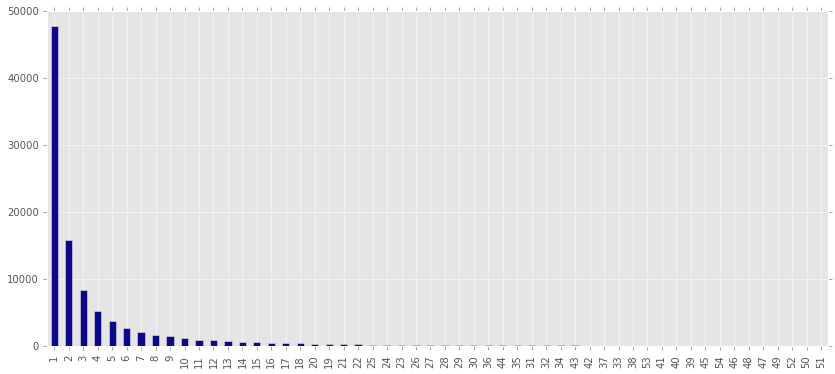

In [43]:
print 'Distribution of the rows with missing values in the train set'
(Training.shape[1] - Training.count(axis=1)).value_counts()[1:].plot(kind='bar',
                                                                     figsize=(14, 6), 
                                                                     colormap=plt.get_cmap("plasma"))

Distribution of the rows with missing values in the test set


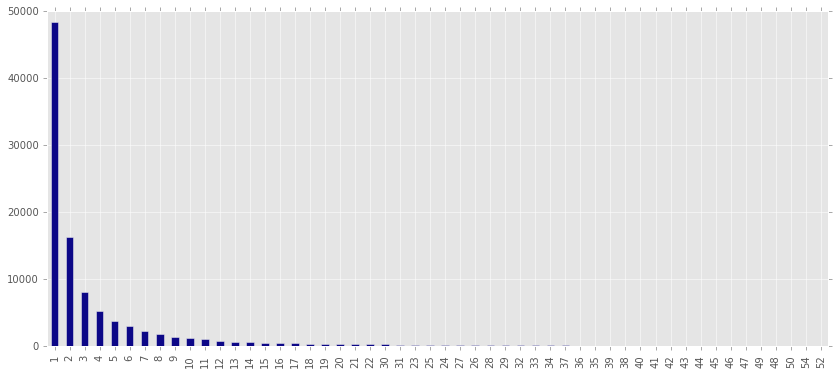

In [44]:
print 'Distribution of the rows with missing values in the test set'
(Testing.shape[1] - Testing.count(axis=1)).value_counts()[1:].plot(kind='bar',
                                                                   figsize=(14, 6),
                                                                   colormap=plt.get_cmap("plasma"))

The distribution are quite the same, between the train set and the test set.    
We also looked for the features with the most missing values.

Distribution of the missing values in the train set by features


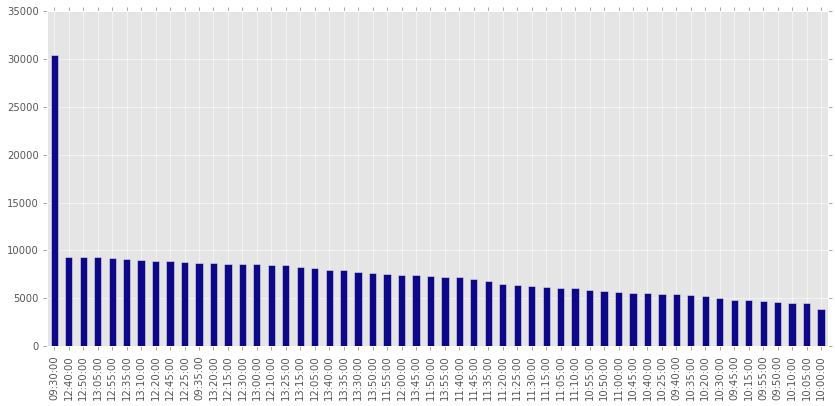

In [45]:
print 'Distribution of the missing values in the train set by features'
(Training.shape[0] - Training.count(axis=0)).sort_values(ascending=False)[:-3].plot(kind='bar',
                                                                                    figsize=(14, 6),
                                                                                    colormap=plt.get_cmap("plasma"))

Distribution of the missing values in the test set by features


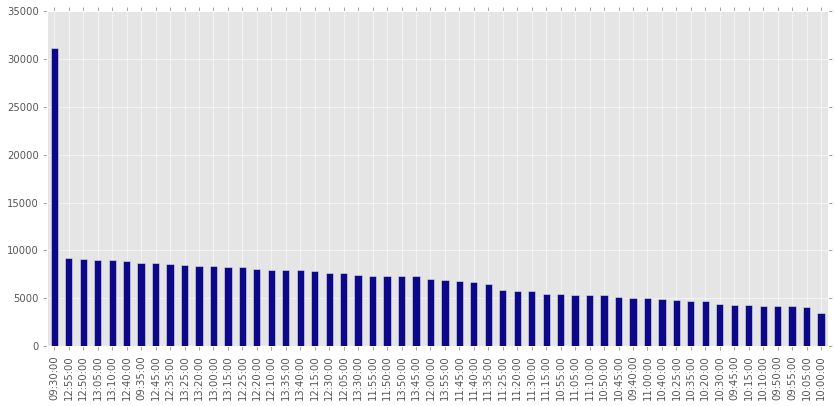

In [46]:
print 'Distribution of the missing values in the test set by features'
(Testing.shape[0] - Testing.count(axis=0)).sort_values(ascending=False)[:-3].plot(kind='bar',
                                                                                  figsize=(14, 6),
                                                                                  colormap=plt.get_cmap("plasma"))

We clearly see that the two graphs are very similar, with a sur-representation of the missing values for the first temporal variable '09:30:00'.

## II. Our supervised model, without the missing values

To have a good initial understanding of the quality of our predictor, we remove here all the examples with missing entries, and build our prediction model on the fully-filled data.

In [38]:
train = pd.merge(Training, Output, on='ID', how='inner')
train_full = train.drop(pd.isnull(train).any(1).nonzero()[0]).reset_index(drop=True)

### II. A. Unfruitul attempts
Many predictors were tested during this phase, a large part of it coming from the sklearn library.    
One great issue for us was the format of the data : having a time-series dataset in place of a classical feature matrix led us to search for a convenient frequential or time-frequential decomposition, e.g. a representation in a Discrete Fourier Transform/Discrete Wavelet Transform basis.

We used a Daubechies wavelet dictionary, with different numbers of vanishing moments. As we recall, the Daubechies wavelets with only one vanishing moment is the Discrete Fourier transform.

#### II. A. I. Discrete Wavelet Transform.

Wavelelets $\phi_{Q}$ are translations and dilatations of an initial function $\phi$. 

In the following we will thus consider a family of $\mathbb{L}^{2}(\mathbb{R})$, $(\phi_{jk})_{j,k \in \mathbb{Z}}$ such that : 
$$\phi_{jk}(t) = 2^{\frac{j}{2}}\phi(2^{j}t-k)  \phi \in \mathbb{L}^{2}(\mathbb{R}).$$
$\phi$ is called the scaling function.
 
Mallat suggested an algorithm allowing a very fast wavelet decomposition computation.
The theoretical framework is based on _Multiresolution Analysis_ ; we call Multiresolution Analysis a family $(V_{j})_{j \in \mathbb{Z}}$ of $\mathbb{L}^{2}(\mathbb{R})$ subsets with the following properties : 

$$V_{j} = \{ \sum_{k \in \mathbb{Z}} a_{k}\phi_{jk} : a_{k} \in \mathbb{R} \}$$
$$V_{j} \subset V_{j+1}$$
$$\bigcap_{j \in \mathbb{Z}} V_{j} = \{0\} $$
$$\overline{\bigcup_{j \in \mathbb{Z}} V_{j}} = \mathbb{L}^{2}(\mathbb{R}).$$

Here $\phi \in V_{0} \subset V_{1}$, $\exists$ $(m_{0}[k])_{k \in \mathbb{Z}}$ such that :
$$
 \phi(t) = 2\sum_{k \in \mathbb{Z}} m_{0}[k]\phi(2t-k).
$$

We call the sequence $(m_{0})$ the first filter. Wavelets are seen as a way to describe _at level j_ the difference between the two subsets $V_{j}$ and $V_{j+1}$. 

A particularly interesting level is the level $0$ :
$ \exists W_{0} |
V_{0}\oplus W_{0} = V_{1}.$

And there exists a function $\psi$, called _mother wavelet_, that generates $W_0$ : 
$$
W_{0} = \{ t \mapsto \sum_{k \in \mathbb{Z}} d_{k} \psi(t-k) : d_{k} \in \mathbb{R} \}
$$

Since $\psi \in V_{1}$, there is a sequence $(m_{1})$ such that :
$$
\psi(t) = \sum_{k \in \mathbb{Z}} m_{1}[k]\phi(2t-k)
$$
$(m_{1})$ is the second filter. 

The interesting thing about these filters is that their specification provides the whole information about the wavelet decomposition, through the following formulas :
$$
\hat{\phi}(w) = \prod_{k = 1}^{+ \infty} m_{0}(\frac{w}{2^{k}})
\hat{\psi}(w) = m_{1}(\frac{w}{2})\hat{\phi}(\frac{w}{2})
$$

Let us note $W_{j}$ such that $\forall j \in \mathbb{Z}, V_{j+1} = V_{j} \oplus W_{j}$. Then :
$$
\mathbb{L}^{2}(\mathbb{R}) = \bigoplus_{j=-\infty}^{+\infty} W_{j} = V_{j} \oplus \bigoplus_{k=j}^{+\infty} W_{k}.
$$

**Computing the decomposition**

Due to the intricate connection between the subsets, we reason iteratively and compute at each step the following basis shift :
$$
V_{j+1} \leftrightarrow V_{j} \oplus W_{j}
$$

Since $(\phi_{j,k})_{k \in \mathbb{Z}}$ is a basis of $V_{j}$
and $(\psi_{j,k})_{k \in \mathbb{Z}}$ a basis of $W_{j}$, the problem consists in finding the following transformation :

$$
\{ \phi_{j+1,k} : k \in \mathbb{Z}\} \leftrightarrow \{\phi_{j,k} : k \in \mathbb{Z}\} \cup \{ \psi_{j,k} : k \in \mathbb{Z}\}
$$

With $(a_{j+1,k})_{k \in \mathbb{Z}}$, (respectively $(a_{j,k})_{k \in \mathbb{Z}}$ and $(d_{j,k})_{k \in \mathbb{Z}}$), the coordinates of a signal in $V_{j+1}$ (resp. $V_{j}$ and $W_{j}$), the problem is equivalent to :
$$
l_{2}(\mathbb{Z}) \rightarrow l_{2}(\mathbb{Z}) \times l_{2}(\mathbb{Z})$$
$$
(a_{j+1,k})_{k \in \mathbb{Z}} \rightarrow [(a_{j,k})_{k \in \mathbb{Z}} ; (d_{j,k})_{k \in \mathbb{Z}}]
$$

The filters $(m_{0})$ and $(m_{1})$ will play a key role in the computation of the discrete wavelet transform and its inverse.
Indeed, for any $j \in \mathbb{Z}$, we have the following transform formulas  : 

**Inverse wavelet transform**: 
$$
a_{j+1,k} = \frac{1}{2} \sum_{l \in \mathbb{Z}} m_{0}[2l-k]a_{j,l}+m_{1}[2l-k] d_{j,l}.
$$
**Forward wavelet transform**:
$$
a_{j,k} = 2 \sum_{l \in \mathbb{Z}} \tilde{m}_{0}[l] a_{j+1,2l-k}
$$
$$
d_{j,k} = 2 \sum_{l \in \mathbb{Z}} \tilde{m}_{1}[l] d_{j+1,2l-k}.
$$

In practice, when processing signals, we only have sampled values at times [$t_{1}$,...,$t_{n}$] - so that we deal with elements of $\mathbb{R}^{n}$ instead of $\mathbb{L}^{2}(\mathbb{R})$. In this case, there is a level of resolution $j$ such that the observed signal $y \in V_{j}$. In other words, there is a level of resolution which contains the whole information. 

Suppose that we want to represent the vector $y$ on level $j-2$.

$\bullet$ **First Step :** we project the signal on
$
V_{j-1} \oplus W_{j-1}.
$

$\bullet$ **Second Step :** we project the signal on
$
V_{j-2} \oplus W_{j-2} \oplus W_{j-1}.
$

We obtain $3$ vectors $cA$ (the signal projected on $V_{j-2}$), $cD_{j-2}$ and $cD_{j-1}$ (the signal projected respectively on $W_{j-2}$ and $W_{j-1}$) ; we proceed iteratively to finally obtain vectors $cA,cD_{1},...,cD_{j-1}$.

Concatenated vector $\lambda = [cA,cD_{1},...,cD_{j-1}]^T$ represents the wavelet decomposition of an example y, in our model.
This decomposition allows us to handily create the transposed wavelet dictionary, by implementing it on the canonical basis of $\mathbb{R}^n$ : we obtain a matrix $G$, such that every decomposition $\lambda$ of a time series $y$ can be written $\lambda=Gy$.
$G^T$ becomes our explanatory dictionary.

In [98]:
import pywt

class DictT(object):

    def __init__(self, name, level):
            self.name = name
            self.level = level
            self.sizes = []

    def dot(self, mat):

        m = []

        if mat.shape[0] != mat.size:
            for i in xrange(mat.shape[1]):
                c = pywt.wavedec(mat[:, i], self.name, level=self.level)
                self.sizes.append(map(len, c))
                c = np.concatenate(c)
                m.append(c)
            return np.asarray(m).T
        else:
            c = pywt.wavedec(mat, self.name, level=self.level)
            self.sizes.append(map(len, c))
            return np.concatenate(c)

Now, to compute the transformation for the matrix X, we simply replace it by the following ('db20' are Daubechies wavelets with 20 vanishing moments) : 

In [99]:
wave_name = 'db20'
wave_level = None
wavelet_operator_t = DictT(level=wave_level, name=wave_name)

basis_t = wavelet_operator_t.dot(np.identity(X.shape[1]))
basis_t /= np.sqrt(np.sum(basis_t ** 2, axis=0))
basis = basis_t.T

Now X becomes X.dot(basis) as an input for the regression model. Unfortunately, the Discrete Wavelet Transform (or Fourier Transform) gives us poorer results than simplest methods as the final one, described below. Furthermore, when dealing with missing values, the DWT/DFT of interpolated data (see section below) introduces the interpolation noise at all levels, and makes this representation an unconvenient choice in this challenge.

#### II. A. II. Convolutional Neural Networks.

We also looked at Deep Learning models for our regression phase. Amongst others, we tried LSTM and Convolutional Neural Networks on the dataset. As one of the participants within the team had a laptop with Nvidia GPU for faster calculation, we rented an Amazon Web Services EC2-G2 Cluster, with 1 GPU and 8 CPU, to train our Deep Learning models.

We used the library Keras to easily form the Networks, and played vastly with parameters, including the learning step for the Adam optimizer, the number of filters or the filter length for each Convolutional Layer.

Unfortunately, no parameter configuration gave us a training score lower than 32%. We remain confident that this approach still holds a lot of potential, and that we could obtain greater results with more experiments.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten
from keras.optimizers import Adam

# Reshape data.

train_shape = (x_train.shape[0], x_train.shape[1], 1)
val_shape = (x_val.shape[0], x_val.shape[1], 1)

x_train_2 = np.reshape(x_train, train_shape).astype(theano.config.floatX)
x_val_2 = np.reshape(x_val, val_shape).astype(theano.config.floatX)

# CNN Model.

model = Sequential()
model.add(Convolution1D(nb_filter=16,
                        filter_length=2,
                        init='glorot_uniform',
                        input_shape=(x_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Convolution1D(nb_filter=32,
                        filter_length=4,
                        init='glorot_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

learning_rate = 10
batch_size = 100
nb_epoch = 10

adam = Adam(lr=learning_rate)
model.compile(loss='mean_absolute_percentage_error', optimizer=adam)

print 'Training | Batch size :', batch_size, ", Number of epochs :", nb_epoch
model.fit(x_train_2, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          validation_data=(x_val_2, y_val), show_accuracy=True)
score, acc = model.evaluate(x_val_2, y_val, batch_size=batch_size,
                            show_accuracy=True)

print 'Test score :', score
print 'Test accuracy:', acc

### II. B. Final Regressor

After testing various predictors, our main choice was the $\textsf{RandomForestRegressor}$, with a parameter selection using $\textsf{GridSearchCV}$ on a shortened dataset. This was the only reasonable method to perform a grid search, considering the large training times occuring on such large data.

In [39]:
features = train_full.drop(['ID','product_id','TARGET'], axis=1)
X_columns = train_full.columns.drop(['ID','product_id','TARGET'])
X = features.values
y = train_full['TARGET'].values

In [40]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [67]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

n_estimators = 50
max_depth = 15
max_features = 40
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print "MAPE :", mean_absolute_percentage_error(y_test, y_pred)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16 µs


Using our trained predictor, we can now focus on the importance of each variable.

In [ ]:
ordering = np.argsort(reg.feature_importances_)[::-1]
importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

pd.DataFrame(importances, index=feature_names).plot(kind='bar', figsize=(14, 6), colormap=plt.get_cmap("plasma"))

We tried to relaunch the model without the features of lowest importance, which can bring noise in our regression. We try several possibilities, but the results weren't very convincing to fully remove them.     
However, we dropped the 'date' from further models, considering it had the least importance within the entire pool of variables.

As mentioned earlier, we tried several other models without great success. Here is an example of an $\textsf{AdaBoostRegressor}$ evaluated on the same data :

In [39]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostRegressor

regto = AdaBoostRegressor(base_estimator=reg, n_estimators=20, learning_rate=0.8)

regto.fit(X_train, y_train)

y_pred = regto.predict(X_test)

print "MAPE :", mean_absolute_percentage_error(y_test, y_pred)

MAPE : 36.379279734
CPU times: user 6min 59s, sys: 2.79 s, total: 7min 2s
Wall time: 7min 7s


## III. Dealing with missing values
### III. A. Removing the first temporal variable

As we saw earlier, the first temporal variable '09:30:00' accounts for a large amount of the missing data.    
Moreover, we see that this variable has one of the least importance in our model ; hence, we decided to remove it from future predictions.    
The effect of this removal was the augmentation the train set size, as we only took observations without missing values — without changing the performance of our model.

In [57]:
Training_new = train.copy()
Training_new.drop(["09:30:00"], axis=1, inplace=True)
print train.shape
print Training_new.shape

 (613220, 58)
(613220, 57)


In [58]:
print 'Number of rows without missing values with the feature 09:30:00 in train set :', train.\
    drop(pd.isnull(train).any(1).nonzero()[0]).shape[0]
print 'Number of rows without missing values without the feature 09:30:00 in train set :', Training_new.\
    drop(pd.isnull(Training_new).any(1).nonzero()[0]).shape[0]

Number of rows without missing values with the feature 09:30:00 in train set : 513947
Number of rows without missing values without the feature 09:30:00 in train set : 534215


In [59]:
Testing_new = Testing.copy()
Testing_new.drop(["09:30:00"], axis=1, inplace=True)
print Testing.shape
print Testing_new.shape

(614098, 57)
(614098, 56)


In [60]:
print 'Number of rows without missing values with the feature 09:30:00 in train set :', Testing.drop(pd.isnull
                                                                        (Testing).any(1).nonzero()[0]).shape[0]
print 'Number of rows without missing values without the feature 09:30:00 in train set:', Testing_new.drop(pd.isnull
                                                                        (Testing_new).any(1).nonzero()[0]).shape[0]

Number of rows without missing values with the feature 09:30:00 in train set : 514539
Number of rows without missing values without the feature 09:30:00 in train set: 535162


In the test set and the train set, this method allows us to gain around 20000 observations without missing values.     
We thus gain in size for the train set and the observations of the test set that we can predict with our model.

In [61]:
train_full = Training_new.drop(pd.isnull(Training_new).any(1).nonzero()[0])

In [62]:
features = train_full.drop(['ID','product_id','date','TARGET'], axis=1)
X_columns = train_full.columns.drop(['ID','product_id','date','TARGET'])
X = features.values
y = train_full['TARGET'].values

In [63]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [64]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

n_estimators = 50
max_depth = 15
max_features = 40
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print "MAPE :", mean_absolute_percentage_error(y_test, y_pred)

MAPE : 29.6441237583
CPU times: user 17min 55s, sys: 12.1 s, total: 18min 7s
Wall time: 19min 7s


### III. B. Filling missing values

We tried several techniques to interpolate the missing values : sklearn's $\textsf{Imputer}$ (the worst we tried), as well as the entire range of pandas' interpolation techniques inherited from scipy.     
We will onyl present here only our best result : the time interpolation method from scipy.

We separate the train set into two subsets : the observations without missing values (train_filled) and the observations with missing values (train_missing).

In [68]:
train_filled = Training_new.drop(pd.isnull(Training_new).any(1).nonzero()[0]).reset_index(drop=True)
train_missing = Training_new[~Training_new["ID"].isin(train_filled["ID"].tolist())]
print train_filled.shape

(534215, 57)


We present time-wise interpolation for one single row, with missing values.

Missing values : 28


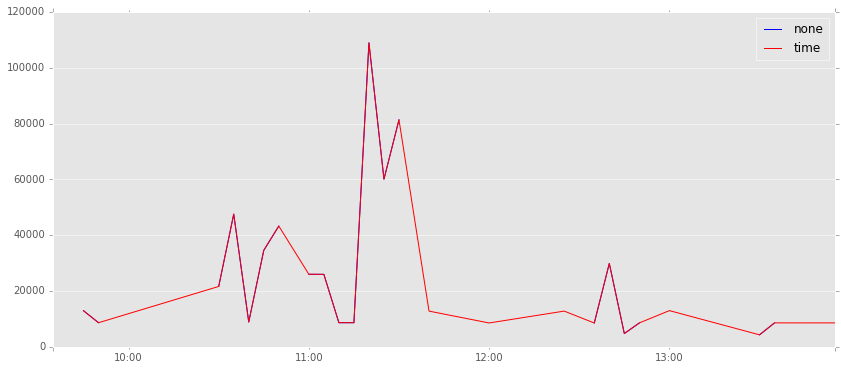

In [77]:
row = train_missing.drop(["ID", "date", "product_id", "TARGET"], axis=1).ix[613193] # [62691]
row.index = pd.to_datetime(row.index)
print "Missing values :", np.isnan(row).sum()

d = {"time": row.interpolate(method="time"),"none": row}
pd.DataFrame(d).plot(colormap=plt.get_cmap("bwr"), figsize=(14, 6))

We then filled all the observations.

In [100]:
def fill_missing_time(row):
    
    row.index = pd.to_datetime(row.index)
    return row.interpolate(method="time").fillna(method="backfill")

numeric_cols = train_missing.columns.drop(["ID", "date", "product_id", "TARGET"])
train_missing[numeric_cols] = train_missing[numeric_cols].apply(fill_missing_time, axis=1)

In [153]:
train_full = pd.concat([train_filled, train_missing], axis=0)
print "Dataset shape after filling :\n", train_full.shape

Dataset shape after filling :
(613199, 57)


In [154]:
features = train_full.drop(["ID", "date", "product_id", "TARGET"], axis=1)
X_columns = train_full.columns.drop(["ID", "date", "product_id", "TARGET"])
X, y = features.values, train_full['TARGET'].values

In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [91]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

n_estimators = 50
max_depth = 15
max_features = 40
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print "MAPE :", mean_absolute_percentage_error(y_test, y_pred)

MAPE : 29.6429418639
CPU times: user 18min 14s, sys: 13.5 s, total: 18min 28s
Wall time: 19min 53s


We tested here only on the observations with missing values, the result is pretty bad.

## IV. Workaround without interpolation

One important remark : the metric we use penalizes not only the distance between the true value and the value predicted, but also the relative position of these two.     

For example let us denote $y_{pred}$ our prediction and $y_{true}$ the true value: if $y_{pred} = 10$ and $y_{true} = 100$, the distance between the two is 90 and the MAPE is 90%; but if $y_{pred} = 100$ and $y_{true} = 10$, the distance is still 90 but the MAPE is now 900%. That is why we decided, for the examples with too many missing values, to assign the minimum if the TARGET in the train set for this product. This way, we have a maximum of 100% error for these observations. That's a way to limit the error for the observations with missing values. 

So we test this on the observations of the train set with missing values.

In [92]:
train_filled = Training_new.drop(pd.isnull(Training_new).any(1).nonzero()[0]).reset_index(drop=True)
train_missing = Training_new[~Training_new["ID"].isin(train_filled["ID"].tolist())]

print 'train_filled',train_filled.shape
print 'train_missing',train_missing.shape

train_filled (534215, 57)
train_missing (79005, 57)


In [93]:
min_per_product_id = train.groupby("product_id").agg({"TARGET": np.min})

validation_under = train_missing[["ID", "product_id"]].copy().join(min_per_product_id, on="product_id")
validation = validation_under.sort_values(by="ID")

print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, validation["TARGET"].values)

MAPE : 83.5862773074


So for these observations we have a MAPE of 84%. But we observed also that by product, the feature 'TARGET' has a large standard deviation (almost equal to the mean).

In [80]:
mean_per_product_id = train.groupby("product_id").agg({"TARGET": np.mean})
mean_per_product_id.columns = ['TARGET_mean']

std_per_product_id = train.groupby("product_id").agg({"TARGET": np.std})
std_per_product_id.columns = ['TARGET_std']

pd.concat([mean_per_product_id, std_per_product_id], axis=1).head()

,TARGET_mean,TARGET_std
product_id,,
236,24157732.043920,17776699.155772
238,5825229.925770,4655058.589438
242,19649724.759512,15224305.210163
243,8249545.655585,6406010.022325
261,30402004.119214,20845333.894698


It means that the minimum is far from the other values. So we decided to use not the minimum but a value above, but a readjustment of it instead. 

In [81]:
print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, validation["TARGET"].values)
print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, 2 * validation["TARGET"].values)
print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, 3 * validation["TARGET"].values)
print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, 4 * validation["TARGET"].values)
print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, 5 * validation["TARGET"].values)

MAPE : 83.5862773074
MAPE : 69.9682064614
MAPE : 62.706405248
MAPE : 61.7711984429
MAPE : 65.5130846126


Using ground trial, we settled for the following value of minimal readjustment :

In [90]:
print "MAPE :", mean_absolute_percentage_error(train_missing["TARGET"].values, 3.65 * validation["TARGET"].values)

MAPE : 61.480089348


## V. Prediction on the test set
As we did earlier, we separate our test set into two subsets : one without any missing entry, and the rest.    
In the first case, we will use our trained regressor for the prediction ; in the second case, we will control the error by outputing the readjusted minimal value per product.

In [ ]:
test_filled = Testing_new.drop(pd.isnull(Testing_new).any(1).nonzero()[0]).reset_index(drop=True)
test_missing = Testing_new[~Testing_new["ID"].isin(test_filled["ID"].tolist())]

We train our model on the entire set.

In [ ]:
train_full = Training_new.drop(pd.isnull(Training_new).any(1).nonzero()[0])

In [ ]:
features = train_full.drop(['ID','product_id','date','TARGET'], axis=1)
X_columns = train_full.columns.drop(['ID','product_id','date','TARGET'])
X = features.values
y = train_full['TARGET'].values

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

n_estimators = 50
max_depth = 15
max_features = 40
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

reg.fit(X, y)

We predict the target value for the rows without missing entries.

In [ ]:
y_pred_filled = reg.predict(test_filled[numeric_cols].values)

submission_filled = test_filled[["ID", "product_id"]].copy()
submission_filled["TARGET"] = y_pred_filled
submission_filled.head()

For the rest, we output the readjusted minimal value per product.

In [ ]:
min_per_product_id = train.groupby("product_id").agg({"TARGET": np.min})
min_per_product_id.head()

In [ ]:
submission_missing = test_missing.copy().join(min_per_product_id, on="product_id")
submission_missing.head()

In [ ]:
submission_missing["TARGET"] = 3.65 * submission_missing["TARGET"]

We finally concatenate the results, sort by ID, and output them in the format required for the challenge.

In [ ]:
submission = pd.concat([submission_filled, submission_missing], axis=0).sort_values(by="ID")
submission = submission[['ID','TARGET']]
print submission.shape
submission.head()

In [ ]:
submission.to_csv("Submission.csv", sep=";", index=False)